In [123]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import lognorm
from scipy.stats import norm
import math
import seaborn as sns
from random import sample

In [2]:
graph = {}
with open('fb_graph.pkl', 'rb') as f:
    graph = pickle.load(f)
G = nx.from_dict_of_dicts(graph)

In [106]:
for i in range(len(G.nodes)):
    G.nodes[i]["status"] = "S"
nx.set_node_attributes(G, False, name = "confirmed positive")
nx.set_node_attributes(G, False, name = "tested")
nx.set_node_attributes(G, False, name = "infected")
nx.set_edge_attributes(G, name = "weight", values = 1)

In [107]:
G.nodes.data()

NodeDataView({0: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 1: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 2: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 3: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 4: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 5: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 6: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 7: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 8: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 9: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 10: {'status': 'S', 'confirmed positive': False, 'tested': False, 'infected': False}, 11: {'status': 'S', 'confirmed positive': False, '

In [108]:
len(list((nx.get_node_attributes(G,'status'))))

4039

In [109]:
c=0
for i in range(len(nx.degree_histogram(G))):
    if nx.degree_histogram(G)[i]>0:
        c=i
        
print(c)

1045


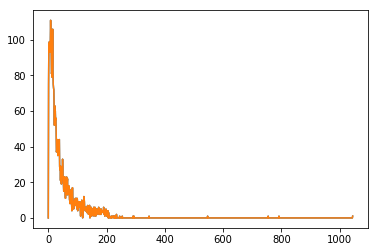

In [140]:
plt.plot(nx.degree_histogram(G))
plt.show()

In [111]:
np.sum(np.multiply(np.array(list(range(len(nx.degree_histogram(G))))),np.array(nx.degree_histogram(G))))

176466

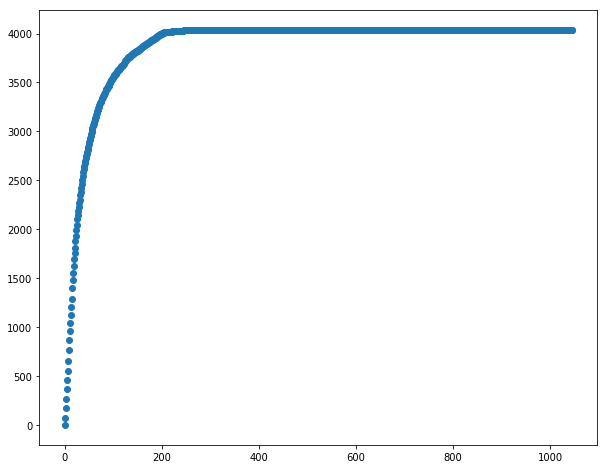

In [112]:
plt.figure(figsize=(10,8))
plt.scatter(list(range(len(nx.degree_histogram(G)))),np.cumsum(nx.degree_histogram(G)))
plt.show()

In [113]:
.2/43.7

0.004576659038901602

In [148]:
def run_iteration(G, test = False):
    S_n = [n for n,v in G.nodes(data=True) if v['status'] == 'S']
    E_n = [n for n,v in G.nodes(data=True) if v['status'] == 'E']
    I_n = [n for n,v in G.nodes(data=True) if v['status'] == 'I']
    H_n = [n for n,v in G.nodes(data=True) if v['status'] == 'H']
    for i in I_n:
        for neighbor in G.neighbors(i):
            if G.nodes[neighbor]["status"] == "S":
                # Multiplying by the weight of the edge is supposed to model decreased 
                # contact after a person is in quarentine
                if random.random() < 0.004576659038901602*G[i][neighbor]["weight"]:
                    G.nodes[neighbor]["status"] = "E"
                    G.nodes[neighbor]["days_since_E"] = 0
    for e in E_n:
        G.nodes[e]["days_since_E"] += 1
        days_since_E = G.nodes[e]["days_since_E"]
        if days_since_E == 14: # if you've been asymp for 14 days, you recover
            G.nodes[e]["status"] = "R"
        mu = 1.621
        std = 0.418
        prob = lognorm.pdf(days_since_E, s=std, scale=np.exp(mu)) * 0.8
        if random.random() < prob:
            G.nodes[e]["status"] = "I"
            G.nodes[e]["days_since_I"] = 0
    for i in I_n:
        G.nodes[i]["days_since_E"] += 1
        G.nodes[i]["days_since_I"] += 1
        days_since_I = G.nodes[i]["days_since_I"]
        dist = norm(10, 1) 
        prob = dist.pdf(days_since_I) * 0.1755
        if random.random() < prob:
            G.nodes[i]["status"] = "H"
            G.nodes[i]["days_since_H"] = 0
    for h in H_n:
        G.nodes[h]["days_since_H"] += 1
        G.nodes[h]["days_since_E"] += 1
        if G.nodes[h]["days_since_E"] == 14:
            if random.random() < 0.01:
                G.nodes[h]["status"] = "D"
            else:
                G.nodes[h]["status"] = "R"
                
    # If we do testing, we now update the nodes depending on the test passed in 
    if test == "random":
        test_strat_random_sample(G, 4)
    elif test == "high_connect":
        test_strat_high_contact(G, 150)
    elif test == "pool_family":
        test_strat_pool_family(G)
    

In [142]:
# Choose 10 people at random to be infected initially
first_infected = random.sample(list(T.nodes()), 10)

In [177]:
# Copy the graph 4 times so we can use one clean copy for each modeling iteration 
T = G.copy()
T_1 = G.copy() 
T_2 = G.copy()
T_3 = G.copy()
# Also make each copy reflect the infected status from the initial infections
for i in first_infected:
    T.nodes[i]["status"] = "I"
    T.nodes[i]["days_since_E"] = 0
    T.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_1.nodes[i]["status"] = "I"
    T_1.nodes[i]["days_since_E"] = 0
    T_1.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_2.nodes[i]["status"] = "I"
    T_2.nodes[i]["days_since_E"] = 0
    T_2.nodes[i]["days_since_I"] = 0
for i in first_infected:
    T_3.nodes[i]["status"] = "I"
    T_3.nodes[i]["days_since_E"] = 0
    T_3.nodes[i]["days_since_I"] = 0

In [178]:
# Store the number of infections
infected_num = []
infected_num_random = []
infected_num_connect = []
infected_num_family = []

# Run each model for 50 time steps
print("Starting the no testing model")
for i in range(50):
    I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
    infected_num.append(len(I_n))
    run_iteration(T)
    if i % 10 ==0:
        print("done", i, "iter")
print("Starting the random testing model")
for i in range(50):
    I_n = [n for n,v in T_1.nodes(data=True) if v['status'] == 'I']
    infected_num_random.append(len(I_n))
    run_iteration(T_1, "random")
    if i % 10 ==0:
        print("done", i, "iter")
print("Starting the testing highly connected people model")
for i in range(50):
    I_n = [n for n,v in T_2.nodes(data=True) if v['status'] == 'I']
    infected_num_connect.append(len(I_n))
    run_iteration(T_2, "high_connect")
    if i % 10 ==0:
        print("done", i, "iter")

        
#TODO: This one takes a long time to run because we are finding the cliques each time,
# instead we should probably change it so we find the cliques once, store it globally 
# or pass it into the function as a parameter to speed up runtime
        
# for i in range(100):
#     I_n = [n for n,v in T_3.nodes(data=True) if v['status'] == 'I']
#     infected_num.append(len(I_n))
#     run_iteration(T_3, "pool_family")

done 0 iter
done 10 iter
done 20 iter
done 30 iter
done 40 iter
done 0 iter
done 10 iter
done 20 iter
done 30 iter
done 40 iter
done 0 iter
done 10 iter
done 20 iter
done 30 iter
done 40 iter


In [ ]:
S_n = [n for n,v in T.nodes(data=True) if v['status'] == 'S']
E_n = [n for n,v in T.nodes(data=True) if v['status'] == 'E']
I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
H_n = [n for n,v in T.nodes(data=True) if v['status'] == 'H']

In [95]:
print(E_n)
print(I_n)
print(H_n)

[6, 10, 21, 56, 118, 122, 146, 158, 161, 172, 224, 361, 420, 426, 473, 495, 512, 520, 523, 531, 545, 557, 569, 575, 598, 623, 627, 632, 646, 654, 666, 669, 898, 900, 903, 938, 962, 987, 989, 1097, 1098, 1118, 1228, 1246, 1294, 1295, 1311, 1350, 1436, 1453, 1490, 1494, 1510, 1588, 1618, 1648, 1656, 1701, 1759, 1818, 1930, 1956, 1958, 1960, 1999, 2061, 2067, 2085, 2160, 2162, 2186, 2217, 2228, 2365, 2383, 2406, 2415, 2439, 2466, 2497, 2610, 2612, 2639, 2647, 2658, 2660, 2687, 2697, 2711, 2754, 2772, 2787, 2822, 2836, 2854, 2877, 2883, 2911, 2957, 2964, 2968, 2984, 3002, 3062, 3078, 3162, 3170, 3176, 3196, 3211, 3215, 3232, 3276, 3287, 3300, 3346, 3352, 3356, 3365, 3458, 3496, 3498, 3602, 3603, 3608, 3635, 3667, 3707, 3714, 3768, 3773, 3777, 3809, 3869, 3880, 3891, 3911, 3931, 3933, 3945]
[7, 29, 58, 67, 76, 107, 136, 147, 168, 211, 213, 223, 236, 285, 301, 304, 322, 324, 353, 355, 367, 370, 375, 391, 392, 397, 398, 402, 408, 409, 414, 417, 431, 432, 433, 442, 444, 451, 452, 455, 460, 465

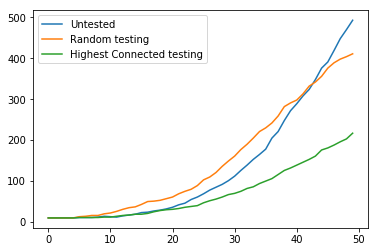

In [179]:
plt.plot([i for i in range(50)], infected_num[0:50], label = "Untested")
plt.plot([i for i in range(50)], infected_num_random[0:50], label = "Random testing")
plt.plot([i for i in range(50)], infected_num_connect[0:50], label = "Highest Connected testing")

plt.legend()
plt.show()

In [173]:
quarantine_infectivity = 0.1
confirmed_negative_infectivity = 1

FAMILY_CLIQUE_SIZE = 4

def update_positive_tests(graph, confirmed_positive_nodes, confirmed_negative_nodes):
    '''
    Takes a graph and a list of confirmed positves and confirmed negativess and updates the 
    node and weight attributes to reflect that they were tested 
    
    graph: networkx graph from model
    confirmed_positive_nodes: Nodes that were confirmed to be positive via testing 
    confirmed_negative nodes: Nodes that were confirmed to be negative via testing

    mutates the graph (edges and weights) to reflect probable behavior changes after testing

    NOTE: Currently it is not multaplicative for things of the same type, but it is for things of different 
    type

    '''

    # Set confirmed attribute for confirmed postive
    confirmed_pos_dic = {n : True for n in confirmed_positive_nodes}
    nx.set_node_attributes(graph, confirmed_pos_dic, name = "confirmed positive")

    # Set tested attribute for confirmed negative
    confirmed_neg_dic = {n : True for n in confirmed_negative_nodes}
    nx.set_node_attributes(graph, confirmed_pos_dic, name = "tested")
    nx.set_node_attributes(graph, confirmed_neg_dic, name = "tested")

    # Set edge weights for confirmed positive
    cp_edges = graph.edges(confirmed_positive_nodes)
    weight = nx.get_edge_attributes(graph, "weight")
    cp_edges = (e if e in weight else (e[1], e[0]) for e in cp_edges)
    updated_edges = {e: weight[e]*quarantine_infectivity for e in cp_edges}
    nx.set_edge_attributes(graph, name = "weight", values = updated_edges)

    # Set edge weights for confirmed negative 
    cn_edges = graph.edges(confirmed_negative_nodes)
    weight = nx.get_edge_attributes(graph, "weight")
    cn_edges = (e if e in weight else (e[1], e[0]) for e in cn_edges)
    updated_edges = {e: weight[e]*confirmed_negative_infectivity for e in cn_edges}
    nx.set_edge_attributes(graph, name = "weight", values = updated_edges)


def perform_test(graph, tested_nodes):
    '''
    Tests each node of tested_nodes in graph.

    Parameters:
        'graph' : NetworkX graph to be analyzed
        'tested_nodes' : list of nodes to be tested

    Returns:
        positive_nodes, negative_nodes : lists of nodes that tested positive and negative, respectively
    '''
    positive_nodes = []
    negative_nodes = []
    for node in tested_nodes:
        if graph.nodes[node]['status'] == 'I':
            positive_nodes.append(node)
        else:
            negative_nodes.append(node)
    return positive_nodes, negative_nodes

def test_strat_random_sample(graph, n):
    '''
    Randomly select n nodes of the graph to be tested; tests those nodes and mutates graph accordingly.

    Parameters: 
        "graph" : NetworkX graph to be analyzed
        "n" : Number of nodes to be tested; nonnegative integer and must be no larger than the number of nodes in the graph.
    Returns:
        list of nodes that were tested
    '''

    tested_nodes = sample(list(graph.nodes()), n)
    positive_nodes, negative_nodes = perform_test(graph, tested_nodes)
    update_positive_tests(graph, positive_nodes, negative_nodes)
    return tested_nodes

def test_strat_high_contact(graph, d):
    '''
    Test all nodes with degree greater than or equal to d in graph and mutates graph accordingly.

    Parameters: 
        "graph" : NetworkX graph to be analyzed
        "d" : nonnegative integer; nodes with degree greater than or equal to d will be tested.
    Returns:
        list of nodes that were tested

    '''
    node_deg_pairs = list(graph.degree())
    
    tested_nodes = [node for node, deg in node_deg_pairs if deg>=d]
    '''
    for node, deg in node_deg_pairs:
        if deg >= d:
            tested_nodes.append(node)
    '''
    positive_nodes, negative_nodes = perform_test(graph, tested_nodes)
    update_positive_tests(graph, positive_nodes, negative_nodes)
    return tested_nodes

def test_strat_pool_family(graph):
    '''
    Test all nodes that are part of families (defined as maximal cliques of specified size or greater) in graph. Mutates graph accordingly.

    Parameters:
        "graph" : NetworkX graph to be analyzed
    Returns:
        list of nodes that were tested
    '''

    tested_nodes = []
    max_cliques = nx.find_cliques(graph)
    tested_nodes = [clique for clique in max_cliques if len(clique) >= FAMILY_CLIQUE_SIZE]
    return tested_nodes